# Stock Feature Pipeline

This notebook converts the raw data from the apis into model inputs


In [1]:
# Import the required libraries and load in the environment variables
import hopsworks
import os
from dotenv import load_dotenv

import requests
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


plt.style.use('grayscale')

# Load the .env file
load_dotenv()

# Get the environment variables
tiingo_api_key = os.getenv("TIINGO_API_KEY")
hopsworks_api_key = os.getenv("HOPSWORKS_API_KEY")
alpha_vantage_key = os.getenv("ALPHA_VANTAGE_KEY")

### Getting Data From API


#### Generate Dataset from API getting last year data


In [2]:

def create_dataset_chunk(start_date: str, end_date: str, ticker="AMZN", freq: str = '60min') -> pd.DataFrame:

    # Format the url with start_data, end_data and freq
    url = f"https://api.tiingo.com/iex/{ticker}/prices?startDate={start_date}&endDate={end_date}&resampleFreq={freq}&token={tiingo_api_key}"
    response = requests.get(url).json()

    return pd.DataFrame(response)


# df = create_dataset_chunk("2024-01-01", "2024-02-29")  # Test the function

In [3]:
years = [2023, 2024]

for i in range(len(years) - 1):
    print(years[i], years[i + 1])

2023 2024


In [4]:

def create_supervised_dataset(years: list, ticker: str = "AMZN", freq: str = '60min') -> pd.DataFrame:
    """
    Generates a supervised dataset from DataFrame chunks based on the provided date ranges.

    Args:
        dates (dict): A dictionary where keys are start dates and values are end dates.
        ticker (str): The stock ticker symbol. Default is "AMZN".
        freq (str): The frequency of the data. Default is '60min'.

    Returns:
        pd.DataFrame: A DataFrame containing the concatenated data for all date ranges.
    """
    # Initialize an empty DataFrame to store the concatenated data
    data = pd.DataFrame(create_dataset_chunk(start_date='2022-06-07', end_date='2022-12-31', ticker=ticker, freq=freq))

    # Iterate over each date range in the dates dictionary
    for i in tqdm(range(len(years) - 1)):
        # Create a DataFrame chunk for the given date range, ticker, and frequency
        df = create_dataset_chunk(
            start_date=f"{years[i]}-01-01", end_date=f"{years[i+1]}-12-31", ticker=ticker, freq=freq)

        # Concatenate the new chunk with the existing data
        data = pd.concat([data, df])

        # Get the current year stock market data
    data = pd.concat([data, create_dataset_chunk('2025-01-01', '2025-02-20')])

    # Change the date column to datetime format
    data['date'] = data['date'].map(lambda x: x.split('.')[0])
    data['date'] = pd.to_datetime(data['date'])

    # Set the index as the date column
    data = data.set_index("date")
    # Return the concatenated DataFrame
    return data.sort_index()

In [5]:
# Call the function
data = create_supervised_dataset(years, "AMZN")

data.head()

100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


,close,high,low,open
date,,,,
2022-06-07 14:00:00,123.350,124.090,121.55,122.440
2022-06-07 15:00:00,122.420,123.375,121.53,123.360
2022-06-07 16:00:00,121.670,122.500,121.03,122.500
2022-06-07 17:00:00,122.085,122.475,121.40,121.680
2022-06-07 18:00:00,122.190,122.810,121.95,122.085


In [6]:
data.head(10)

,close,high,low,open
date,,,,
2022-06-07 14:00:00,123.350,124.090,121.55,122.440
2022-06-07 15:00:00,122.420,123.375,121.53,123.360
2022-06-07 16:00:00,121.670,122.500,121.03,122.500
2022-06-07 17:00:00,122.085,122.475,121.40,121.680
2022-06-07 18:00:00,122.190,122.810,121.95,122.085
2022-06-07 19:00:00,123.000,123.540,122.17,122.190
2022-06-08 14:00:00,122.575,123.700,122.25,123.300
2022-06-08 15:00:00,122.670,123.250,122.08,122.575
2022-06-08 16:00:00,121.565,122.860,121.02,122.600


In [7]:
data.tail()

,close,high,low,open
date,,,,
2025-02-20 16:00:00,222.38,223.070,221.810,222.085
2025-02-20 17:00:00,222.57,223.035,222.110,222.370
2025-02-20 18:00:00,222.27,222.580,222.180,222.560
2025-02-20 19:00:00,222.49,222.830,222.040,222.270
2025-02-20 20:00:00,222.85,223.080,222.335,222.490


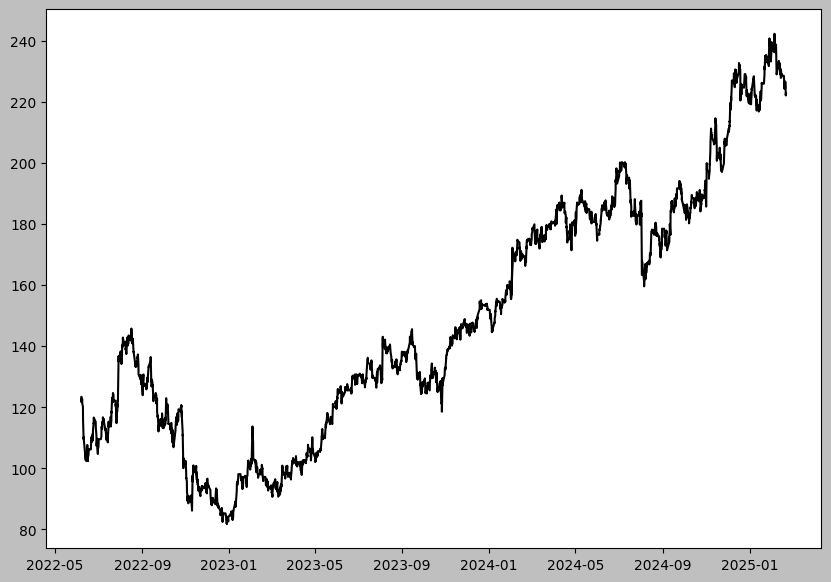

In [8]:

plt.figure(figsize=(10, 7))
plt.plot(data.index, data["close"])
plt.show()

## Data Ingestion to Feature Store


In [9]:
# reset the index 
data = data.reset_index()

# Add the id column as primary key
data["id"] = [str(date) for date in data['date']]

In [10]:
data.head()

,date,close,high,low,open,id
0,2022-06-07 14:00:00,123.350,124.090,121.55,122.440,2022-06-07 14:00:00
1,2022-06-07 15:00:00,122.420,123.375,121.53,123.360,2022-06-07 15:00:00
2,2022-06-07 16:00:00,121.670,122.500,121.03,122.500,2022-06-07 16:00:00
3,2022-06-07 17:00:00,122.085,122.475,121.40,121.680,2022-06-07 17:00:00
4,2022-06-07 18:00:00,122.190,122.810,121.95,122.085,2022-06-07 18:00:00


In [11]:
# Login to Hopsworks
project = hopsworks.login(api_key_value = str(hopsworks_api_key))

# Get the feature store
fs = project.get_feature_store()

2025-02-21 21:06:26,129 INFO: Initializing external client
2025-02-21 21:06:26,129 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-02-21 21:06:29,130 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1212597


In [12]:
# Create feature group
amazon_fg = fs.get_or_create_feature_group(
    name="amazon_stock_prices",
    description="Amazon last 5 year stock prices",
    version=1,
    online_enabled=True,
    primary_key=["id"],
    event_time="date"
)

# Insert into feature group
amazon_fg.insert(data)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1212597/fs/1200226/fg/1401414


Uploading Dataframe: 100.00% |██████████| Rows 4236/4236 | Elapsed Time: 00:04 | Remaining Time: 00:00


Launching job: amazon_stock_prices_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1212597/jobs/named/amazon_stock_prices_1_offline_fg_materialization/executions


(Job('amazon_stock_prices_1_offline_fg_materialization', 'SPARK'), None)

In [13]:
# Create a list of dictionaries with column names and descriptions
column_descriptions = [
    {'name': 'date', 'description': 'The date and time of the stock data'},
    {'name': 'close', 'description': 'The closing price of the stock'},
    {'name': 'high', 'description': 'The highest price of the stock during the period'},
    {'name': 'low', 'description': 'The lowest price of the stock during the period'},
    {'name': 'open', 'description': 'The opening price of the stock'},
    {'name': 'id', 'description': 'primary key'}
]

for desc in column_descriptions:
    amazon_fg.update_feature_description(desc['name'], desc['description'])